# Stochastic model

##### M. Kretzschmar et al., Modeling  Prevention  Strategies for  Gonorrhea  and Chlamydia  Using Stochastic  Network  Simulations,  Am  J Epidemiol   1996;144:306-17

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time

from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

In [4]:
class Person:
    """
    Definition for the Person-class
    
    Generates a Person which is defined by
    identifier:           unique number which is also the Person's index in the
                          System.persons list
    gender:               The Person's gender. Takes value 0 : male or 1 : female
    age:                  The Person's age. Can be between 15 and 65
    days:                 Number of days the Person has aged from its birthday. Can be
                          any value between 0 and 364
    sexual_activity:      The Person's sexual activity. Can be 1 (high) in ages
                          between 15 and 35, and 0 (low) otherwise
    disease_status:       Can be 0 : not infected, 1 : symptomatically infected
                          with non-resistant variant, 2 : asymptomatically infected
                          with non-reseistant variant, 3: symptomatically infected
                          with resistant variant, and 4 : asymptomatically infected
                          with resistant variant
    time_since_infection: Self-explanatory. Defaults to -1 if not infected
    number_of_partners:   integer representing the number of partners for this
                          Person
    current_partners:     Set containing the unique identifiers of Persons in which
                          this Person has a partnership
    """
    def __init__(self,i,gender, age, days, sexual_activity):
        """
        Initialization function for the Person-class
        
        Input:
        i:               unique identifier for this Person
        gender:          integer representing gender, can be 0 : male or 1 : female
        age:             integer representing age, can be between 15 and 64
        days:            number of days past last birthday of this Person, can be between 0 and 364
        sexual_activity: whether this Person has high (1) or low (0) sexual activity
        
        Further variables are set as follows
        disease_status = 0 (uninfected)
        time_since_infection = -1 (null value)
        number_of_partners = 0 (no partners)
        current_partners = empty set (no partners)
        """
        
        self.identifier = i
        self.gender = gender
        self.days = days
        self.age = age
        self.sexual_activity = sexual_activity
        self.disease_status = 0
        self.time_since_infection = -1
        self.number_of_partners = 0
        self.current_partners = set()
    
    def increase_time(self,s):
        """
        Performs one timestep for this Person.
        
        Increases days by one, and the time_since_infection if this Persons is infected. Also
        calls increase_age if days equals 365
        """
        self.days += 1
        if self.disease_status > 0:
            self.time_since_infection += 1
        if self.days == 365:
            self.increase_age(s)
    
    def increase_age(self,s):
        """
        Increases the age of this Person.
        
        Sets sexual activity to low if the Person is 35 of age or older. Also updates the age_group
        this Person is part of.
        """
        self.age += 1
        self.days = 0
        if self.age >= 35 and self.sexual_activity == 1:
            self.sexual_activity = 0
            s.high_sexual_activity.remove(self.identifier)
        
        #exclude age == 65; they will be replaced next timestep
        if self.age % 10 == 5 and self.age < 65:
            age_group = int(np.floor((self.age+5)/10))-2
            s.age_group[age_group-1].remove(self.identifier)
            s.age_group[age_group].add(self.identifier)
                    
    def print_state(self):
        """
        Prints the full state of this Person
        """
        print(self.identifier, 
              self.gender, 
              self.age,
              self.sexual_activity,
              self.disease_status,
              self.time_since_infection,
              self.number_of_partners,
              self.current_partners)
    
    def add_partner(self, other_person,s):
        """
        Add a partner to this Person
        
        Updates the number_of_partners and adds the unique identifier to its current_partners-set        
        """
        if self.number_of_partners == 0:
            #no longer single!
            s.number_of_singles -= 1
            s.singles.remove(self.identifier)
        if other_person.identifier not in self.current_partners:
            #only add if not already in a partnership
            self.number_of_partners += 1
            self.current_partners.add(other_person.identifier)
        
    def remove_partner(self, other_person,s):
        """
        Remove a partner from this Person
        
        Note: if the other Person is not in this Person's current_partner-set, this function
        returns a KeyValue error
        """
        self.number_of_partners -= 1
        self.current_partners.remove(other_person.identifier)
        
        if self.number_of_partners == 0:
            #no partners left -> single
            s.number_of_singles += 1
            s.singles.add(self.identifier)
    
    def asymptomatic_infection(self, s):
        """
        Infects this Person with the asymptomatic non-resistant disease
        
        Note: only allows Persons which are susceptible to become infected
        """
        if self.disease_status == 0:
            self.disease_status = 2
            self.time_since_infection = 0
            s.number_of_asymptomatic += 1
            s.infected.add(self.identifier)
        
    def symptomatic_infection(self, s):
        """
        Infects this Person with the symptomatic non-resistant disease
        
        Note: only allows Persons which are susceptible to become infected
        """
        if self.disease_status == 0:
            self.disease_status = 1
            self.time_since_infection = 0
            s.number_of_symptomatic += 1
            s.infected.add(self.identifier)
    
    def resistant_symptomatic_infection(self, s):
        """
        Infects this Person with the symptomatic resistant disease       
        """
        if self.disease_status == 0:
            self.time_since_infection = 0
            s.infected.add(self.identifier)
            s.resistant.add(self.identifier)
        elif self.disease_status == 1:
            s.number_of_symptomatic -= 1
            s.resistant.add(self.identifier)
        self.disease_status = 3
        s.number_of_res_symp += 1
        
    def resistant_asymptomatic_infection(self, s):
        """
        Infects this Person with the asymptomatic resistant disease
        """
        if self.disease_status == 0:
            self.time_since_infection = 0
            s.infected.add(self.identifier)
            s.resistant.add(self.identifier)
        elif self.disease_status == 1:
            s.number_of_symptomatic -= 1
            s.resistant.add(self.identifier)
        self.disease_status = 4
        s.number_of_res_asymp += 1
        
    def cure(self, s):
        """
        Cures this Person from any disease
        """
        if self.disease_status == 1:
            s.number_of_symptomatic -= 1
        elif self.disease_status == 2:
            s.number_of_asymptomatic -= 1
        elif self.disease_status == 3:
            s.number_of_res_symp -= 1
        elif self.disease_status == 4:
            s.number_of_res_asymp -= 1
        if self.disease_status > 0:
            s.infected.remove(self.identifier)
        if self.disease_status > 2:
            s.resistant.remove(self.identifier)
        self.disease_status = 0
        self.time_since_infection = -1
        
class Partnership:
    """
    Definition for the Partnership-class
    
    Generates a Partnership between two Persons which is defined by
    type:    type of partnership, can be 1 (steady) or 2 (casual)
    persons: list containing the two Persons in this Partnership    
    """
    
    def __init__(self,partnership_type,person1,person2,s):
        """
        Initialization function for the Partnership-class
        
        Input:
        partnership_type: defines the type of Partnership. Can be 1 (steady) or 2 (casual)
        person1: Person-object for the first Person
        person2: Person-object for the second Person
        
        Also calls the add_partner-function for both Persons to update their current partners
        """
        
        self.type = partnership_type
        self.persons = [person1,person2]
        
        person1.add_partner(person2,s)
        person2.add_partner(person1,s)
        
    def remove(self,s):
        """
        Removes the Partnership between the Persons involved.
        
        Note: Does not remove the Partnership-object
        """
        
        p1, p2 = self.persons
        
        p1.remove_partner(p2,s)
        p2.remove_partner(p1,s)
    
    def print_state(self):
        """
        Prints the state of this Partnership
        """
        print(self.type,
              self.persons[0].identifier,
              self.persons[1].identifier)

class System:
    """
    Definition of the System-class
    
    Generates a System which is defined by
    
    persons: list of Person-objects in the System
    partnerships: list of Partnership-objects in the System
    straight_males: set of Person-identifiers of male Persons
    females: set of Person-identifiers of female Persons
    high_sexual_activity: set of Person-identifiers of highly sexually active Persons
    singles: set of Person-identifiers of singles
    infected: set of Person-identifiers of infected (disease_status > 0) Persons
    resistant: set of Person-identifiers of infecteds with the resistant variant (disease_status > 2)
    age_group: list of sets for age_groups 15 - 24, 25 - 34, 35 - 44, 45 - 54, 55 - 64
    age_group_mixing_prob: mixing probabilities between age_groups as defined by age_group_mixing()
    age_groups: list of tuples for all combinations of age_groups between two Persons
    time: integer containing the current time of the System
    number_*: counts for some properties
    other: several parameters
    
    """
    def __init__(self):
        """
        Initialization function for the System-class
        
        See System-class definition
        """
        self.persons = []
        self.partnerships = []
        self.straight_males = set()
        self.females = set()
        self.high_sexual_activity = set()
        self.singles = set()
        self.infected = set()
        self.resistant = set()
        self.age_group = [set() for x in range(5)]
        self.age_group_mixing_prob = age_group_mixing()
        self.age_groups = [(i,j) for i in range(5) for j in range(5)]
        self.time = 0
        self.number_of_symptomatic = 0
        self.number_of_asymptomatic = 0
        self.number_of_res_symp = 0
        self.number_of_res_asymp = 0
        self.number_of_steady = 0
        self.r0_infected = []
    
    def set_constants(self,
                      f = 0.2,
                      rho = 0.006,
                      sigma1 = 0.0004,
                      sigma2 = 0.1,
                      number_of_persons = 10000,
                      gender_ratio = 0.5,
                      transmission_male_female_steady = 0.15,
                      transmission_female_male_steady = 0.0625,
                      transmission_male_female_casual = 0.6,
                      transmission_female_male_casual = 0.25,
                      asymptomatic_men = 0.1,
                      asymptomatic_women = 0.45,
                      incubation_time_men = 5,
                      incubation_time_women = 10,
                      patient_delay_treatment_men = 5,
                      patient_delay_treatment_women = 8,
                      recovery_rate_asymptomatic_men = 0.0074,
                      recovery_rate_symptomatic_men = 0.04,
                      recovery_rate_asymptomatic_women = 0.0044,
                      recovery_rate_symptomatic_women = 0.03,
                      screening_percentage = 0.02,
                      sexual_activity_high = 0.05,
                      resistance_probability = 0.0001,
                      r0 = False):
        """
        Sets several parameters for the System-class

        Parameters
        f: probability of steady Partnership
        rho: probability of forming a Partnership
        sigma1 : probability of steady partnership separation
        sigma2 : probability of casual partnership separation
        number_of_persons: number of Persons in the System
        gender_ratio: probability of generating a male Person
        transmission_male_female_steady: transmission probability from male to female in a steady Partnership
        transmission_female_male_steady: transmission probability from female to male in a steady Partnership
        transmission_male_female_casual: transmission probability from male to female in a casual Partnership
        transmission_female_male_casual: transmission probability from female to male in a casual Partnership
        asymptomatic_men: probability of contracting the asymptomatic variant for men
        asymptomatic_women: probability of contracting the asymptomatic variant for women
        incubation_time_men: latent period of the disease in days for men
        incubation_time_women: latent period of the disease in days for women
        patient_delay_treatment_men: delay in days before getting treatment for men
        patient_delay_treatment_women: delay in days before getting treatment for women
        recovery_rate_asymptomatic_men: probability of natural recovery for the asymptomatic variant for men
        recovery_rate_symptomatic_men: probability of natural recovery for the symptomatic variant for men
        recovery_rate_asymptomatic_women: probability of natural recovery for the asymptomatic variant for women
        recovery_rate_symptomatic_women: probability of natural recovery for the symptomatic variant for women
        screening_percentage: percentage of population to be screened
        sexual_activity_high: probability to generate a Person with high sexual activity (if age < 35)
        resistance_probability: probability to contract the resistant disease during treatment
        """
        self.f = f
        self.rho = rho
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.number_of_persons = number_of_persons
        self.gender_ratio = gender_ratio

        self.transmission_male_female_steady = transmission_male_female_steady
        self.transmission_female_male_steady = transmission_female_male_steady
        self.transmission_male_female_casual = transmission_male_female_casual
        self.transmission_female_male_casual = transmission_female_male_casual
        self.asymptomatic_men = asymptomatic_men
        self.asymptomatic_women = asymptomatic_women
        self.incubation_time_men = incubation_time_men
        self.incubation_time_women = incubation_time_women
        self.patient_delay_treatment_men = patient_delay_treatment_men
        self.patient_delay_treatment_women = patient_delay_treatment_women
        self.recovery_rate_asymptomatic_men = recovery_rate_asymptomatic_men
        self.recovery_rate_symptomatic_men = recovery_rate_symptomatic_men
        self.recovery_rate_asymptomatic_women = recovery_rate_asymptomatic_women
        self.recovery_rate_symptomatic_women = recovery_rate_symptomatic_women
        self.screening_percentage = screening_percentage
        self.sexual_activity_high = sexual_activity_high
        self.resistance_probability = resistance_probability
        self.r0 = r0

    
    def initialize(self):
        """
        Initializes the model using current parameters
        
        Generates self.number_of_persons Persons        
        """
        for i in range(self.number_of_persons):
            gender =  0 if np.random.random() < self.gender_ratio else 1
            age = np.random.randint(15,65)
            days = np.random.randint(0,365)
            if age >= 15 and age < 35:
                if np.random.random() < self.sexual_activity_high:
                    sexual_activity = 1
                    self.high_sexual_activity.add(i)
                else:
                    sexual_activity = 0
            else:
                sexual_activity = 0
            
            p = Person(i,gender, age, days, sexual_activity)
            self.persons.append(p)
            if gender == 0:
                self.straight_males.add(i)
            else:
                self.females.add(i)
            self.singles.add(i)
            
            age_group = int(np.floor((age+5)/10))-2
            self.age_group[age_group].add(i)
            
            self.number_of_singles = self.number_of_persons
    
    def replace_person(self,p):
        """
        Replaces a Person in-place
        
        Note: assumes the Person to be replaced has age 65
        """
        p.age = 15
        p.days = 0
        
        self.age_group[4].remove(p.identifier)
        self.age_group[0].add(p.identifier)
        
        if np.random.random() < self.sexual_activity_high:
            p.sexual_activity = 1
            self.high_sexual_activity.add(p.identifier)
        else:
            p.sexual_activity = 0
            
        p.cure(self)
        
        #remove all partnerships where p is involved in
        for i,ps in enumerate(self.partnerships):
            if p.identifier in [ps.persons[0].identifier,ps.persons[1].identifier]:
                ps.remove(self)
                self.partnerships[i] = None
                #if deleting steady partnership
                if ps.type == 1:
                    self.number_of_steady -= 1
        self.partnerships = list(filter(None,self.partnerships))
    
    def print_state(self):
        """
        Print state of all Persons and Partnerships in this System
        """
        print("n\tg\to\ta\tc\ts\ttau\td\tN")
        for p in self.persons:
            p.print_state()
        print("type\tpersons")
        for ps in self.partnerships:
            ps.print_state()
            
    def time_step(self):
        """
        Performs a single timestep consisting of:
        
        1. Partnership formation
        2. Disease transmission
        3. Separation of Partnerships
        4. Replacement
        5. Recovery
        6. Treatment (& contact screening)
        7. Screening
        8. Advance time
        """
        
        #creation of partnerships
        
        #number of potential Partnerships to create
        n = int(len(self.persons)/2) - len(self.partnerships)
        
        for i in range(n):
            if np.random.random() < self.rho:
                
                formed = False
                
                while not formed:
                    #choose age_groups of the male (y) and female (x)
                    idx = np.random.choice(list(range(len(self.age_groups))),p=self.age_group_mixing_prob)
                    x_group, y_group = self.age_groups[idx]

                    #flag when no person satisfying the given criteria exists
                    failed = False

                    prob = np.random.random()
                    
                    #use probabilities as given by mixing probability
                    if prob < 0.2 / 1.168:
                        y = list(self.straight_males & self.singles & self.age_group[y_group])
                        x = list(self.females & self.singles & self.age_group[x_group])
                        partnership_type = 1
                    elif prob < 1 / 1.168:
                        y = list(self.straight_males & self.high_sexual_activity & self.age_group[y_group])
                        x = list(self.females & self.high_sexual_activity & self.age_group[x_group])
                        partnership_type = 2
                    elif prob < 1.08 / 1.168:
                        y = list((self.straight_males - self.high_sexual_activity) & self.singles & self.age_group[y_group])
                        x = list(self.females & self.high_sexual_activity & self.age_group[x_group])
                        partnership_type = 2
                    elif prob < 1.16 / 1.168:
                        y = list(self.straight_males & self.high_sexual_activity & self.age_group[y_group])
                        x = list((self.females - self.high_sexual_activity) & self.singles & self.age_group[x_group])
                        partnership_type = 2
                    elif prob < 1.168 / 1.168:
                        y = list(self.straight_males & self.singles & self.age_group[y_group])
                        x = list(self.females & self.singles & self.age_group[x_group])
                        partnership_type = 2

                    #set failed if the male or female does not exist
                    if len(x) == 0 or len(y) == 0:
                        failed = True

                    #if we can have a match
                    if not failed:
                        y = np.random.choice(y)
                        x = np.random.choice(x)
                        y = self.persons[y]
                        x = self.persons[x]

                        #do not create another partnership if one already exists between y and x
                        if x.identifier not in y.current_partners:
                            p = Partnership(partnership_type, x, y, self)
                            self.partnerships.append(p)

                            if partnership_type == 1:
                                self.number_of_steady += 1
                            formed = True

        #Disease transmission
        for i,partnership in enumerate(self.partnerships):
            p1, p2 = partnership.persons
            s1 = p1.disease_status
            s2 = p2.disease_status
            partnership_type = partnership.type
            
            #only transmit if one Person is infectious
            if s1 > 0 and s2 == 0:
                if p1.gender == 0 and p1.time_since_infection > self.incubation_time_men:
                    infected = p1
                    non_infected = p2
                elif p1.gender == 1 and p1.time_since_infection > self.incubation_time_women:
                    infected = p1
                    non_infected = p2
                else:
                    #not yet infectious
                    continue
            elif s1 == 0 and s2 > 0:
                if p2.gender == 0 and p2.time_since_infection > self.incubation_time_men:
                    infected = p2
                    non_infected = p1
                elif p2.gender == 1 and p2.time_since_infection > self.incubation_time_women:
                    infected = p2
                    non_infected = p1
                else:
                    #not yet infectious
                    continue
            else:
                #no infecteds, so no transmission
                continue
            
            if infected.disease_status > 2:
                resistant = True
            else:
                resistant = False
            
            if self.r0 and infected.identifier == 0:
                self.r0_infected.append(non_infected.identifier)
            
            if infected.gender == 0 and non_infected.gender == 1:
                #male -> female
                if partnership_type == 1:
                    if np.random.random() < self.transmission_male_female_steady:
                        if np.random.random() < self.asymptomatic_women:
                            if resistant:
                                non_infected.resistant_asymptomatic_infection(self)
                            else:
                                non_infected.asymptomatic_infection(self)
                        else:
                            if resistant:
                                non_infected.resistant_symptomatic_infection(self)
                            else:
                                non_infected.symptomatic_infection(self)
                elif partnership_type == 2:
                    if np.random.random() < self.transmission_male_female_casual:
                        if np.random.random() < self.asymptomatic_women:
                            if resistant:
                                non_infected.resistant_asymptomatic_infection(self)
                            else:
                                non_infected.asymptomatic_infection(self)
                        else:
                            if resistant:
                                non_infected.resistant_symptomatic_infection(self)
                            else:
                                non_infected.symptomatic_infection(self)
            elif infected.gender == 1 and non_infected.gender == 0:
                #female -> male
                if partnership_type == 1:
                    if np.random.random() < self.transmission_female_male_steady:
                        if np.random.random() < self.asymptomatic_men:
                            if resistant:
                                non_infected.resistant_asymptomatic_infection(self)
                            else:
                                non_infected.asymptomatic_infection(self)
                        else:
                            if resistant:
                                non_infected.resistant_symptomatic_infection(self)
                            else:
                                non_infected.symptomatic_infection(self)
                elif partnership_type == 2:
                    if np.random.random() < self.transmission_female_male_casual:
                        if np.random.random() < self.asymptomatic_men:
                            if resistant:
                                non_infected.resistant_asymptomatic_infection(self)
                            else:
                                non_infected.asymptomatic_infection(self)
                        else:
                            if resistant:
                                non_infected.resistant_symptomatic_infection(self)
                            else:
                                non_infected.symptomatic_infection(self)

        #Separation of partnerships
        for i,ps in enumerate(self.partnerships):
            partnership_type = ps.type
            
            if partnership_type == 1:
                if np.random.random() < self.sigma1:
                    ps.remove(self)
                    self.partnerships[i] = None
                    self.number_of_steady -= 1
            elif partnership_type == 2:
                if np.random.random() < self.sigma2:
                    ps.remove(self)
                    self.partnerships[i] = None
        self.partnerships = list(filter(None,self.partnerships))
        
        #Replacement
        for p in self.persons:
            if p.age == 65:
                self.replace_person(p)
        
        #Recovery
        for p in self.persons:
            if p.gender == 0 and p.disease_status in [1,3]:
                if np.random.random() < self.recovery_rate_symptomatic_men:
                    p.cure(self)
            elif p.gender == 0 and p.disease_status in [2,4]:
                if np.random.random() < self.recovery_rate_asymptomatic_men:
                    p.cure(self)
            elif p.gender == 1 and p.disease_status in [1,3]:
                if np.random.random() < self.recovery_rate_symptomatic_women:
                    p.cure(self)
            elif p.gender == 1 and p.disease_status in [2,4]:
                if np.random.random() < self.recovery_rate_asymptomatic_women:
                    p.cure(self)
                
        #Treatment
        for p in self.persons:
            #can only get treatment if showing symptoms and non-resistant
            if p.disease_status == 1:
                if np.random.random() < self.resistance_probability:
                    if p.gender == 0:
                        if np.random.random() < self.asymptomatic_men:
                            p.resistant_asymptomatic_infection(self)
                        else:
                            p.resistant_symptomatic_infection(self)
                    else:
                        if np.random.random() < self.asymptomatic_women:
                            p.resistant_asymptomatic_infection(self)
                        else:
                            p.resistant_symptomatic_infection(self)
                else:
                    if p.gender == 0:
                        if p.time_since_infection >= self.incubation_time_men + self.patient_delay_treatment_men:
                            p.cure(self)
                    elif p.gender == 1:
                        if p.time_since_infection >= self.incubation_time_women + self.patient_delay_treatment_women:
                            p.cure(self)
                
#                     #contact tracing, only go through current and first-level partners
#                     for j in p.current_partners:
#                         o = self.persons[j]
#                         o.cure(self)
        
#         #Screening
#         if self.time % 365 == 0:
#             number = int(len(self.persons)*self.screening_percentage)
#             screened = np.random.choice(self.persons,number)
#             for p in screened:
#                 p.cure(self)
        
        #advance time
        self.time += 1
        for p in self.persons:
            p.increase_time(self)
            if p.gender == 0 and p.time_since_infection > self.incubation_time_men:
                p.symptomatic_infection(self)
            elif p.gender == 1 and p.time_since_infection > self.incubation_time_women:
                p.symptomatic_infection(self)
        
def age_group_mixing():
    """
    Returns list of probabilities of mixing between different age groups    
    """
    p = []
    for j in np.linspace(1,5,5):
        for k in np.linspace(1,5,5):
            if j == k:
                p.append(1)
            else:
                p.append(0.2**np.abs(j+1-k))
    p /= sum(p)
    return p

### Initialize model

In [104]:
#initialize System
s = System()
s.set_constants(number_of_persons=1000,sigma1=1/365,sigma2=1/30)
s.initialize()

#initialize lists to store counts
singles_list = []
steady_list = []
partnerships_list = []

#start time steps to reach steady state
start = time.time()
for i in range(3000):
    s.time_step()
    singles_list.append(s.number_of_singles)
    steady_list.append(s.number_of_steady)
    partnerships_list.append(len(s.partnerships))

print("TIME TO INITIALIZE MODEL")
print(time.time() - start)

#print core size (sexual_activity == 1)
core_size = len(s.high_sexual_activity)
print("Core size: %d"%(core_size))

#random infection of the core group
infect = np.random.choice(list(s.high_sexual_activity),int(0.1 * core_size))
for i in infect:
    p = s.persons[i]
    p.asymptomatic_infection(s)

#set System time to zero
s.time = 0

TIME TO INITIALIZE MODEL
10.363111972808838
Core size: 20


### Show some statistics

In [105]:
#print percentage of singles in the System
singles = len(s.singles)/len(s.persons) * 100
print("Percentage of singles: %f"%(singles))

#print percentage having one partner
one_partner = 0
for p in s.persons:
    if len(p.current_partners) == 1:
        one_partner += 1
one = one_partner/len(s.persons) * 100
print("Percentage having one partner: %f"%(one))
print("Percentage having more than one partner: %f"%(100 - singles - one))

Percentage of singles: 52.600000
Percentage having one partner: 46.200000
Percentage having more than one partner: 1.200000


In [106]:
# single_male = [len(s.straight_males & s.singles)/(len(s.straight_males))*100]
# single_female = [len(s.females & s.singles)/len(s.females)*100]
# single_core_male = [len(s.straight_males & s.singles & s.high_sexual_activity)/len(s.straight_males & s.high_sexual_activity)*100]
# single_core_female = [len(s.females & s.singles & s.high_sexual_activity)/len(s.females & s.high_sexual_activity)*100]

# for i in range(365):
#     s.time_step()
#     single_male.append(len(s.straight_males & s.singles)/(len(s.straight_males))*100)
#     single_female.append(len(s.females & s.singles)/len(s.females)*100)
#     single_core_male.append(len(s.straight_males & s.singles & s.high_sexual_activity)/len(s.straight_males & s.high_sexual_activity)*100)
#     single_core_female.append(len(s.females & s.singles & s.high_sexual_activity)/len(s.females & s.high_sexual_activity)*100)
    
# print(np.mean(single_male))
# print(np.mean(single_female))
# print(np.mean(single_core_male))
# print(np.mean(single_core_female))

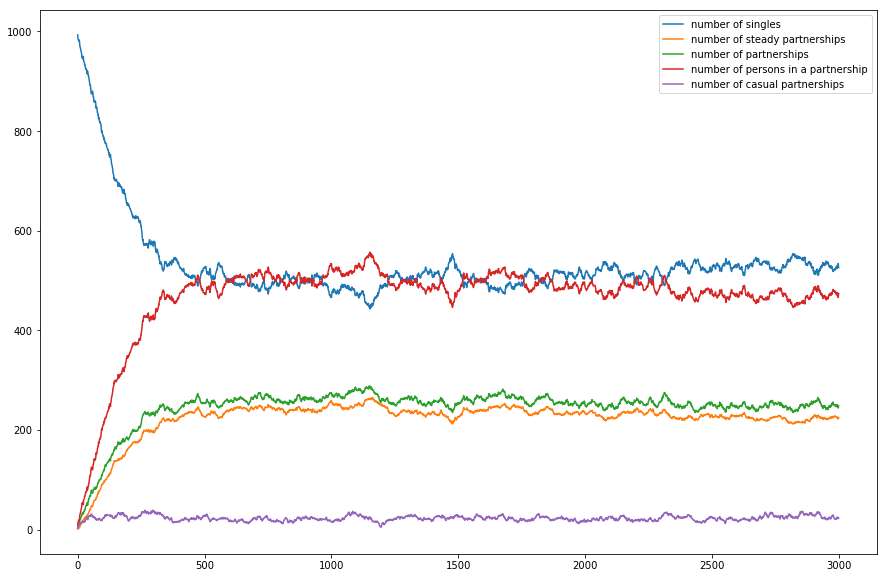

In [107]:
#plot change over time, reaching the steady state
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(singles_list,label="number of singles")
ax.plot(steady_list,label="number of steady partnerships")
ax.plot(partnerships_list,label="number of partnerships")
ax.plot(len(s.persons)-np.array(singles_list),label="number of persons in a partnership")
ax.plot(np.array(partnerships_list) - np.array(steady_list),label="number of casual partnerships")
ax.legend()

### Evolve the system over time

In [108]:
#initialize lists
singles_list = [s.number_of_singles]
steady_list = [s.number_of_steady]
partnerships_list = [len(s.partnerships)]
symptomatic_list = [s.number_of_symptomatic]
asymptomatic_list = [s.number_of_asymptomatic]
res_symp_list = [s.number_of_res_symp]
res_asymp_list = [s.number_of_res_asymp]

#store starting time
start = time.time()

for i in range(25000):
    #make a single time step
    s.time_step()
    
    #append new values to lists
    singles_list.append(s.number_of_singles)
    steady_list.append(s.number_of_steady)
    partnerships_list.append(len(s.partnerships))
    symptomatic_list.append(s.number_of_symptomatic)
    asymptomatic_list.append(s.number_of_asymptomatic)
    res_symp_list.append(s.number_of_res_symp)
    res_asymp_list.append(s.number_of_res_asymp)

#print evaluation time
print(time.time() - start)

85.6314160823822


### Show population / partnership count evolution in graph

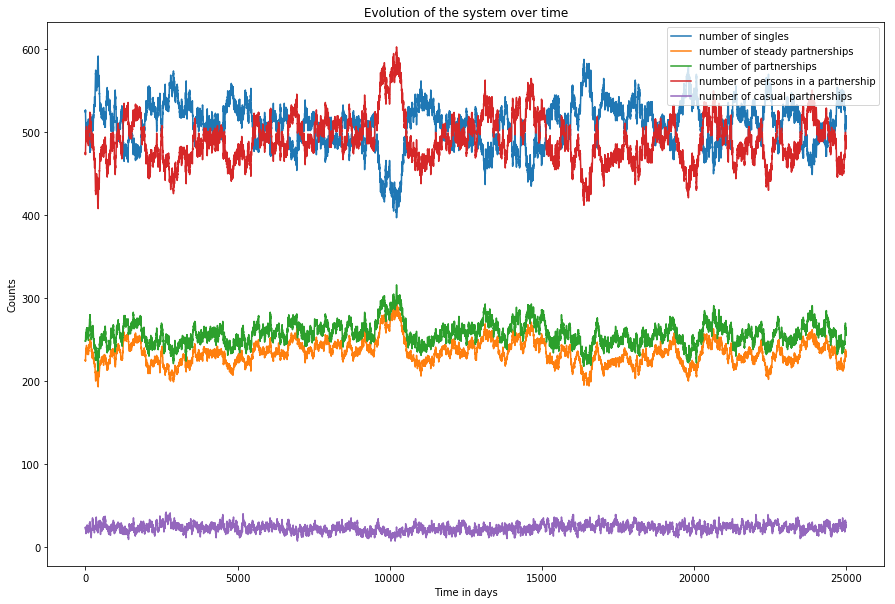

In [109]:
#show change in counts over time
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(singles_list,label="number of singles")
ax.plot(steady_list,label="number of steady partnerships")
ax.plot(partnerships_list,label="number of partnerships")
ax.plot(len(s.persons)-np.array(singles_list),label="number of persons in a partnership")
ax.plot(np.array(partnerships_list) - np.array(steady_list),label="number of casual partnerships")
ax.set_title("Evolution of the system over time")
ax.set_xlabel("Time in days")
ax.set_ylabel("Counts")
ax.legend()

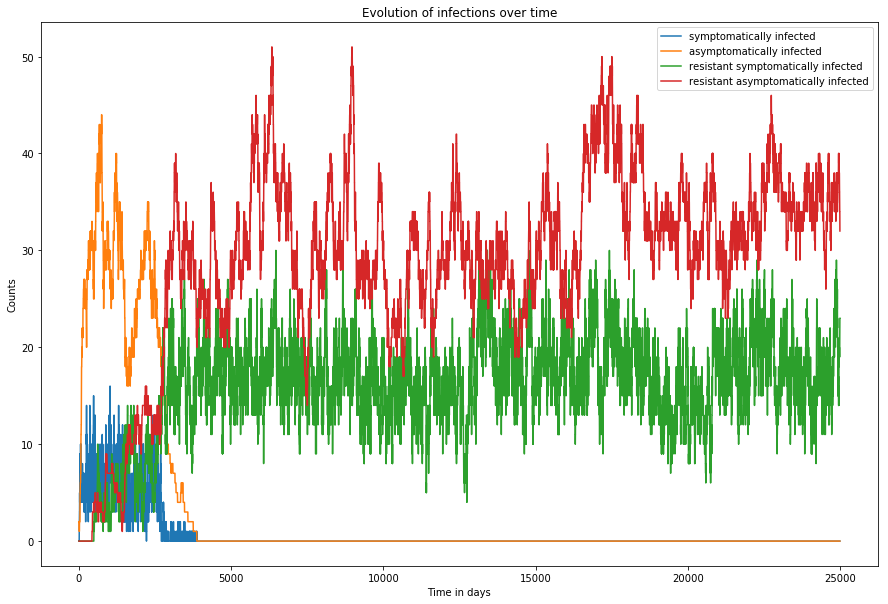

In [110]:
#show change in infecteds over time
fig,ax = plt.subplots(figsize=(15,10))
ax.plot(symptomatic_list,label="symptomatically infected")
ax.plot(asymptomatic_list,label="asymptomatically infected")
ax.plot(res_symp_list,label="resistant symptomatically infected")
ax.plot(res_asymp_list,label="resistant asymptomatically infected")
ax.set_title("Evolution of infections over time")
ax.set_xlabel("Time in days")
ax.set_ylabel("Counts")
ax.legend()

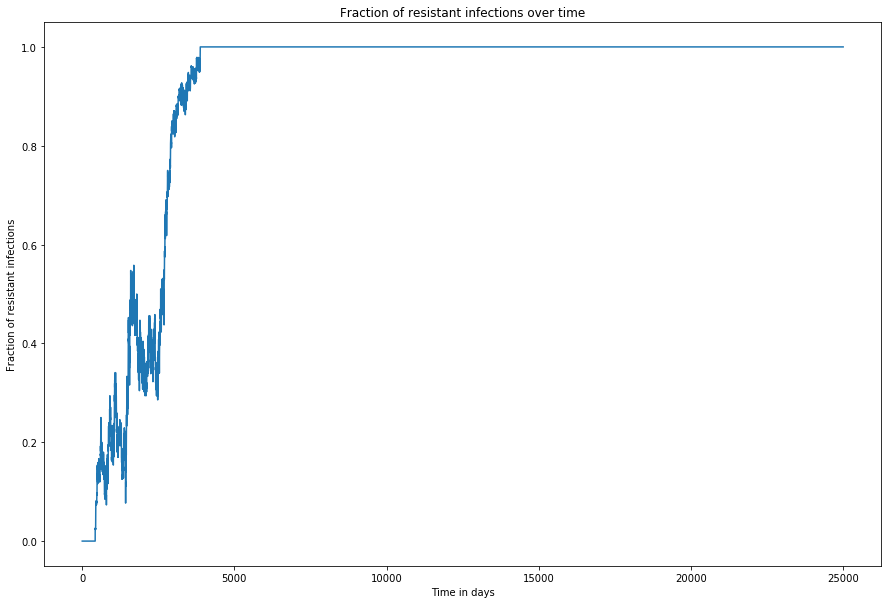

In [111]:
#show change in resistant infections over time
res_inf = np.array(res_symp_list) + np.array(res_asymp_list)
inf = res_inf + np.array(symptomatic_list) + np.array(asymptomatic_list)
fig,ax = plt.subplots(figsize=(15,10))
ax.plot(res_inf/inf)
ax.set_title("Fraction of resistant infections over time")
ax.set_xlabel("Time in days")
ax.set_ylabel("Fraction of resistant infections")

In [112]:
print(len(s.infected))

55


### Animate core group with their (L1) partners

In [115]:
%%capture

#dictionary mapping disease_status to a color
color_dict = {0:'black',1:'red',2:'blue',3:'green',4:'magenta'}

#initialize graph to fix core group in place
# G = nx.Graph()
# G.add_nodes_from(list(s.high_sexual_activity))
# pos = nx.spring_layout(G)

G = nx.Graph()
G.add_nodes_from([p.identifier for p in s.persons])
pos = nx.spring_layout(G)

def plot_graph(i):
    """
    Draw graph for a single time step
    """
    global s,pos,ax
    s.time_step()
    persons = set()
    edges_list = []
    for identifier in s.high_sexual_activity:
        p = s.persons[identifier]
        for partner in p.current_partners:
            persons.add(partner)
            persons.add(identifier)
            edges_list.append((identifier,partner))
    persons_list = sorted(list(persons))

    core = []
    sizes = []
    for identifier in persons_list:
        sizes.append(s.persons[identifier].number_of_partners)
        if s.persons[identifier].sexual_activity == 1:
            core.append('red')
        else:
            core.append('blue')
    disease = []
    for identifier in persons_list:
        disease.append(color_dict[s.persons[identifier].disease_status])
    
    ax.clear()
    G = nx.Graph()
    G.add_nodes_from(persons_list)
    G.add_edges_from(edges_list)
    nx.draw(G,node_color=disease,node_size=20,ax=ax)
    
def plot_all(i):
    """
    Draw graph with all nodes and edges
    """
    
    s.time_step()
    edges_list = []
    
    for ps in s.partnerships:
        edges_list.append((ps.persons[0].identifier,ps.persons[1].identifier))
    persons = []
    core = []
    disease = []
    for p in s.persons:
        if p.sexual_activity == 1:
            core.append('red')
        else:
            core.append('blue')
        disease.append(color_dict[p.disease_status])
        persons.append(p.identifier)
    ax.clear()
    G = nx.Graph()
    G.add_nodes_from(persons)
    G.add_edges_from(edges_list)
    nx.draw(G,pos,node_color=core,node_size=20,ax=ax)
    
fig,ax = plt.subplots(figsize=(15,10))
anim = animation.FuncAnimation(fig,plot_all,frames=1000,interval=20,repeat=True)

In [116]:
anim

# Determine $R_0$

In [6]:
#import to perform in parallel
from joblib import Parallel, delayed

# todo:
#     - possibility to choose high / low sexual activity?
#     - more verbose from model (x infected y)?
#     - check (a)symptomatic case?

#Note that R0 is very high, due to treatment. If Person A is asymptomatic and has a Partnership with Person B,
#who contracts the symptomatic disease, Person B gets treatment. Person A is however still infectious, so Person
#B will almost immediately contract the disease again. To 'solve' this, we convert the list of Person identifiers
#to a set, such that infections are counted uniquely per Person.

def get_R0():
    """
    Gets a single sample of R0 from the System    
    """
    #initialize System
    s = System()
    s.set_constants(r0=True)
    s.initialize()

    #evolve to steady state
    for j in range(1000):
        s.time_step()
    
    #infect Person 0
    s.persons[0].asymptomatic_infection(s)
    
    #loop until Person 0 is cured
    while not s.persons[0].disease_status == 0:
        s.time_step()
    
    #return R0
    return s.r0_infected

#perform 4 jobs in parallel
a = Parallel(n_jobs=4,verbose=5)(delayed(get_R0)() for i in range(1000))

#convert lists to sets, such that we only have the unique Persons infected
a = [len(set(x)) for x in a]

#print R0 with 95% CI
print(a)
print("R_0 = %f +/- %f"%(np.mean(a),1.96*np.std(a)))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 14.1min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 25.8min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 40.4min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 58.7min
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed: 79.9min


[1, 2, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 2, 1, 0, 1, 1, 1, 2, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 2, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 4, 2, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,

[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed: 91.3min finished


In [7]:
a = [1, 2, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 2, 1, 0, 1, 1, 1, 2, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 2, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 4, 2, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 31, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 3, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 26, 1, 1, 1, 4, 14, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 7, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 3, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 2, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 11, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 0, 1, 3, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 1, 3, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 6, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]

In [13]:
a.count(0)

241

In [14]:
a.count(1)

718